In [1]:
import checklist
from checklist.editor import Editor
from checklist.perturb import Perturb
from checklist.test_types import MFT, INV, DIR
from checklist.test_suite import TestSuite
from checklist.expect import Expect

If you read the [paper](https://homes.cs.washington.edu/~marcotcr/acl20_checklist.pdf), you know that CheckList is more than this package, it's also a process.  
This tutorial is a short version of that process, but you should really read the paper if you haven't :)

# Task and Model: QQP, BERT

For the purpose of this tutorial, we'll use Quora Question Pair as an example, with [a finetuned BERT model hosted by Textattack](https://huggingface.co/textattack/bert-base-uncased-QQP).
**Please note that this is not the model reported in the paper -- we finetuned that model locally.** 
Here, we instead use a model that is available online (loaded through [Huggingface Pipeline](https://huggingface.co/transformers/main_classes/pipelines.html)), so that you can easily follow the tutorial.

Loading the model and spacy:

In [2]:
import sys
import spacy
import numpy as np
processor = spacy.load('en_core_web_sm')

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
model_name = "textattack/bert-base-uncased-QQP"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# sentiment analysis is a general name in Huggingface to load the pipeline for text classification tasks.
pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, framework="pt", device=0)

Loading the dataset. First, install the [NLP dataset library](https://huggingface.co/nlp/quicktour.html):

In [3]:
!pip install nlp

In [4]:
from nlp import load_dataset
qqp_data = load_dataset('glue', 'qqp', split='validation')
all_questions = set()
q1s = [d["question1"] for d in qqp_data]
q2s = [d["question2"] for d in qqp_data]
labels = np.array([d["label"] for d in qqp_data]).astype(int)

qs = list(zip(q1s, q2s))
qqp_data[0]

{'idx': 0,
 'label': 0,
 'question1': 'Why are African-Americans so beautiful?',
 'question2': 'Why are hispanics so beautiful?'}

Preprocess all the questions with spacy. This may take sometime.

In [5]:
from tqdm import tqdm
all_questions.update(set(q1s))
all_questions.update(set(q2s))
print(f"Total count of unique questions: {len(all_questions)}")
processed_qs = list(tqdm(processor.pipe(all_questions, batch_size=64)))

1it [00:00,  9.42it/s]

Total count of unique questions: 73324


73324it [01:21, 894.21it/s]


In [6]:
spacy_map = {q: processed_q for (q, processed_q) in zip(all_questions, processed_qs)}
parsed_qs = [(spacy_map[q[0]], spacy_map[q[1]]) for q in qs]

# Top-Down approach: the CheckList matrix

## Capabilities x Test Types

In tutorial #3, we talked about specific test types.  
In order to guide test ideation, it's useful to think of CheckList as a matrix of Capabilities x Test Types.  
*Capabilities* refers to general-purpose linguistic capabilities, which manifest in one way or another in almost any NLP application.   
We suggest that anyone CheckListing a model go through *at least* the following capabilities, trying to create MFTs, INVs, and DIRs for each if possible.
1. **Vocabulary + POS:** important words or groups of words (by part-of-speech) for the task
2. **Taxonomy**: synonyms, antonyms, word categories, etc
3. **Robustness**: to typos, irrelevant additions, contractions, etc
4. **Named Entity Recognition (NER)**: person names, locations, numbers, etc
5. **Fairness**
6. **Temporal understanding**: understanding order of events and how they impact the task
7. **Negation**
8. **Coreference** 
9. **Semantic Role Labeling (SRL)**: understanding roles such as agent, object, passive/active, etc
10. **Logic**: symmetry, consistency, conjunctions, disjunctions, etc

Notice that we are framing this as very top-down approach: you start with a list of capabilities and try to think of what kinds of tests can be created, based on the three test types. We'll talk about how to incorporate some bottom-up thinking later on.

We won't try to create tests for **all** of these capabilities (but we do have notebooks with tests for all of them in the repo), just one as an example. 
Anyway, let's create a test suite (used to save and aggregate tests):

In [7]:
suite = TestSuite()
editor = Editor()

## Capability: NER

Let's start with the NER capability.  
How do named entities impact duplicate question detection? 


### MFT
It seems that the model should at least be able to distinguish questions about different people as non-duplicates.   
Let's write an MFT where we have two people that have the same last name, but different first names.  
Instead of running the test now, we'll add it to the suite and run all tests later.

In [8]:
t = editor.template((
    'Is {first_name} {last_name} {mask}?',
    'Is {first_name2} {last_name} {mask}?',
    ),
    remove_duplicates=True, 
    nsamples=300)
test = MFT(**t, labels=0, name='same adjectives, different people', capability = 'NER',
          description='Different first name, same adjective and last name')
suite.add(test)
print(t.data[0])
print(t.data[1])

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('Is Mary Marshall insane?', 'Is Lynn Marshall insane?')
('Is Don Peterson Jewish?', 'Is Carl Peterson Jewish?')


### INV
If you have two questions with the same named entity, changing the entity on both should not change whether the questions are duplicates or not.  
Let's write an INV for this.

Since we are dealing with pairs of questions, we have to write a wrapper to make sure the same name is changed on both:

In [9]:
def change_name_on_both(qs):
    q1, q2 = qs
    c1 = Perturb.change_names(q1, seed=1, meta=True)
    c2 = Perturb.change_names(q2, seed=1, meta=True)
    if not c1 or not c2:
        return
    # separating out examples and meta. Meta has tuples (a, b), where name 'a' was changed to 'b'
    c1, m1 = c1
    c2, m2 = c2
    # Only include examples where the same name was changed on both questions
    return [(q1, q2) for q1, q2, m1, m2 in zip(c1, c2, m1, m2) if m1 == m2][:10]

In [10]:
t = Perturb.perturb(parsed_qs, change_name_on_both, nsamples=200)
test = INV(**t, name='Change same name in both questions', capability='NER',
          description='')
# test.run(new_pp)
# test.summary(3)
suite.add(test)
print(t.data[0][0])
print(t.data[0][1])
print(t.data[0][2])

('Is Jon Snow still in love with Ygritte?', 'Was Jon Snow in love with Ygritte? What were his feelings towards her?')
('Is Michael Brooks still in love with Ygritte?', 'Was Michael Brooks in love with Ygritte? What were his feelings towards her?')
('Is Christopher Cox still in love with Ygritte?', 'Was Christopher Cox in love with Ygritte? What were his feelings towards her?')


### DIR
Conversely, if an entity is present on a pair the model predicts as a duplicate and we change it to something else on *only one* of the sentences, the prediction should change to non-duplicate.  
Let's write this as a DIR test:

In [11]:
def change_name_on_one(qs):
    q1, q2 = qs
    c1 = Perturb.change_names(q1, seed=1, meta=True)
    c2 = Perturb.change_names(q2, seed=1, meta=True)
    if not c1 or not c2:
        return
    c1, m1 = c1
    c2, m2 = c2
    ret = []
    ret.extend([(q1_, str(q2)) for q1_, m1_ in zip(c1, m1) if m1_[0] in str(q2)])
    ret.extend([(str(q1), q2_) for q2_, m2_ in zip(c2, m2) if m2_[0] in str(q1)])
    return ret

We'll write an expectation function in two steps.  
First, we want the prediction to be 0.  
Second, we only want to include examples where the original prediction is one. We do this with a slice wrapper:

In [12]:
expect_fn = Expect.eq(0)
expect_fn = Expect.slice_orig(expect_fn, lambda orig, *args: orig == 1)


Let's put it all together into a test:

In [13]:
t = Perturb.perturb(parsed_qs, change_name_on_one, nsamples=200)
name = 'Change name in one of the questions'
desc = 'Take pairs that are originally predicted as duplicates, change name in one of them and expect new prediction to be non-duplicate'
test = DIR(**t, expect=expect_fn, name=name, description=desc, capability='NER')
suite.add(test)
print(t.data[0][0])
print(t.data[0][1])
print(t.data[0][2])

('Who do you think will win, Trump or Hillary?', 'Who is going to win, Trump or Hillary?')
('Who do you think will win, Trump or Kayla?', 'Who is going to win, Trump or Hillary?')
('Who do you think will win, Trump or Kimberly?', 'Who is going to win, Trump or Hillary?')


These examples illustrate how thinking through the matrix can help test ideation. We now turn to a bottom up approach

# Bottom up approach

In this approach, we look at specific examples (from the validation dataset or elsewhere) and try to generalize them into MFTs, INVs or DIRs, placing them into a specific capability.  
Here is an example:

In [14]:
np.random.seed(14)
i = np.random.choice(len(qs))
qs[i]

('Which company should I join as a fresher, TCS or Virtusa?',
 'Is it a good decision to join Tcs as a fresher?')

This is a good example, in which a question asks about a comparison between two options, while the other question asks about a single option.  
While they are not duplicates, it is possible that models would get confused here. I think this test fits into the Vocabulary+POS capability (it's not crucial for us to be completely precise about where a test fits).  
Let's try to create an MFT out of it:

In [15]:
', '.join(editor.suggest('{mask} is a large tech company.')[:40])

'Apple, Google, Facebook, This, Microsoft, Amazon, Uber, It, Intel, Samsung, Netflix, Tesla, Twitter, LinkedIn, Oracle, Target, Snap, Disney, AMD, Bloomberg, Sony, That, Wikipedia, China, Here, Fox, this, HP, FB, YouTube, Reddit, Ford, Pinterest, Harris, MIT, GE, CBS, Dialog, Square, Orange'

In [16]:
companies = ['Apple', 'Google', 'Facebook', 'Microsoft', 'Amazon', 'Uber', 'Intel', 'Samsung', 'Netflix', 'Tesla', 'LinkedIn', 'Oracle', 'Target', 'Snap', 'Disney', 'AMD', 'Sony', 'Reddit', 'Youtube']

In [17]:
', '.join(editor.suggest('Should I join {company} as a {mask}?', company=companies)[:30])

'customer, shareholder, member, volunteer, contributor, competitor, contractor, student, professional, buyer, rookie, writer, developer, CEO, manager, consumer, pro, worker, teenager, client, sponsor, person, subscriber, consultant, user, Beta, researcher, director, beta, result'

In [18]:
role = ['developer', 'contributor', 'freshman', 'college grad', 'volunteer', 'writer', 'contractor', 'consultant']

In [19]:
t = editor.template((
       'Which company should I join as a {role}, {company1} or {company2}?',
       'Should I join {company1} as a {role}?',
   ),
    company=companies,
    role=role,
    remove_duplicates=True,
    nsamples=100,
)
print(t.data[0])
print(t.data[1])
print(t.data[2])

('Which company should I join as a contributor, Samsung or Facebook?', 'Should I join Samsung as a contributor?')
('Which company should I join as a volunteer, LinkedIn or Sony?', 'Should I join LinkedIn as a volunteer?')
('Which company should I join as a consultant, Disney or Apple?', 'Should I join Disney as a consultant?')


We've replicated the original example, but we can generalize it a bit to other comparisons:

In [20]:
', '.join([str(x) for x in editor.suggest('Will Google\'s {mask} {mask}?')][:50])

"('dominance', 'continue'), ('strategy', 'work'), ('efforts', 'succeed'), ('success', 'continue'), ('experiment', 'work'), ('dominance', 'last'), ('dominance', 'end'), ('experiment', 'succeed'), ('efforts', 'work'), ('strategy', 'succeed'), ('plan', 'work'), ('growth', 'continue'), ('woes', 'continue'), ('approach', 'work'), ('strategy', 'stick'), ('tactics', 'work'), ('experiments', 'work'), ('failures', 'continue'), ('decision', 'stick'), ('gamble', 'succeed'), ('dominance', 'endure'), ('success', 'last'), ('gamble', 'work'), ('domination', 'continue'), ('lawsuit', 'succeed'), ('push', 'succeed'), ('behavior', 'change'), ('dominance', 'fade'), ('strategy', 'change'), ('dominance', 'return'), ('problems', 'continue'), ('dominance', 'persist'), ('policies', 'change'), ('ambitions', 'succeed'), ('exodus', 'continue'), ('experiments', 'succeed'), ('scandals', 'continue'), ('strategy', 'continue'), ('move', 'work'), ('focus', 'change'), ('crackdown', 'work'), ('plan', 'succeed'), ('domina

In [21]:
t += editor.template((
       'Which company\'s {fverb[0]} will {fverb[1]} {comp}, {company1} or {company2}?',
       'Will {company1}\'s {fverb[0]} {fverb[1]}?',
   ),
    company=companies,
    comp=['most', 'least', 'sooner', 'later'],
    fverb=[('stock', 'rise'), ('CEO', 'quit'), ('board', 'resign'), ('stock', 'fall'), ('effort', 'succeed'), ('strategy', 'work'), ('plan', 'work'), ('gamble', 'work'), ('focus', 'change'), ('intentions', 'change')],
    nsamples=300,
    remove_duplicates=True,
)
print(t.data[-1])
print(t.data[-2])
print(t.data[-3])

("Which company's stock will fall most, Facebook or Google?", "Will Facebook's stock fall?")
("Which company's plan will work later, Uber or Netflix?", "Will Uber's plan work?")
("Which company's gamble will work sooner, Microsoft or Apple?", "Will Microsoft's gamble work?")


In [22]:
test = MFT(**t, labels=0, name='Comparison between two entities is not the same as asking about one', capability = 'Vocabulary',
          description='')
suite.add(test)


# Running the suite, seeing results

When running the prediction, the Huggingface pipeline returns a dict with predicted label and probability:

In [23]:
example = ('Which company should I join as a freshman, Google or Facebook?', 'Should I join Google as a freshman?')
pipe([example])

[{'label': 'LABEL_0', 'score': 0.9871022701263428}]

We write a simple wrapper to make the output compatible with CheckList:

In [24]:
def pred_and_conf(data):
    raw_preds = pipe(data)
    preds = np.array([ int(p["label"][-1]) for p in raw_preds])
    pp = np.array([[p["score"], 1-p["score"]] if int(p["label"][-1]) == 0 else [1-p["score"], p["score"]] for p in raw_preds])
    return preds, pp

In [25]:
suite.run(pred_and_conf)

Running same adjectives, different people
Predicting 299 examples
Running Change same name in both questions
Predicting 2128 examples
Running Change name in one of the questions
Predicting 3793 examples
Running Comparison between two entities is not the same as asking about one
Predicting 378 examples


We can see a (text) summary of the results by calling `suite.summary()`

In [26]:
suite.summary()

Vocabulary

Comparison between two entities is not the same as asking about one
Test cases:      378
Fails (rate):    0 (0.0%)




NER

same adjectives, different people
Test cases:      299
Fails (rate):    55 (18.4%)

Example fails:
0.5 ('Is Frederick Taylor out?', 'Is Caroline Taylor out?')
----
0.8 ('Is Jennifer Clarke Black?', 'Is Andrea Clarke Black?')
----
0.6 ('Is Stephen Martin killed?', 'Is Hugh Martin killed?')
----


Change same name in both questions
Test cases:      200
Fails (rate):    27 (13.5%)

Example fails:
0.0 ("What would have happened if John Lennon hadn't been shot?", 'What if John Lennon were still alive?')
0.8 ("What would have happened if Daniel Myers hadn't been shot?", 'What if Daniel Myers were still alive?')
0.7 ("What would have happened if Joshua Thompson hadn't been shot?", 'What if Joshua Thompson were still alive?')

----
0.2 ('Who is stronger, Luke Cage or Jessica Jones?', 'Who will win in a bed between Luke Cage and She Hulk?')
0.6 ('Who is stronge

Or if we're using jupyter, we can use a nifty visualization that has all of the tests we created in a matrix.  
You can navigate the matrix and see results for individual tests (*The screenshot below is based on our locally finetuned model, so the numbers may not match with your results.*).

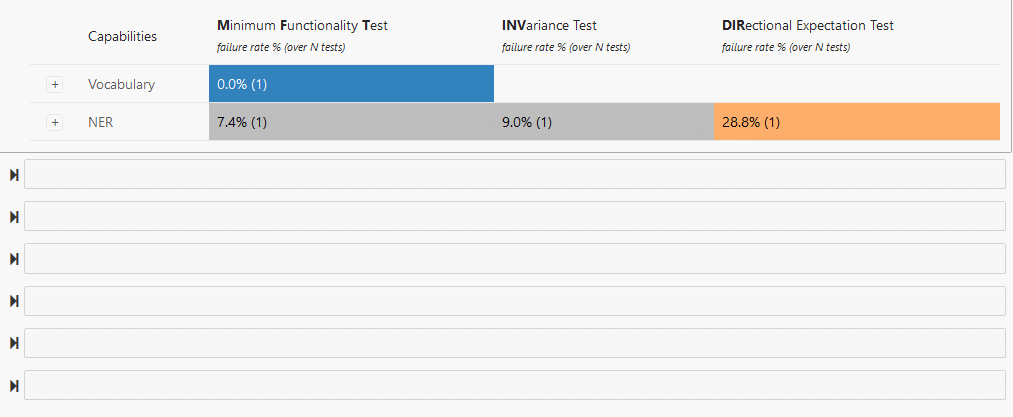

In [41]:
# from IPython.display import HTML, Image
# with open('visual_table_summary.gif','rb') as f:
#     display(Image(data=f.read(), format='png'))
suite.visual_summary_table()

## Bonus: testing Taxonomy

Let's create a few additional tests for the Taxonomy capability

In [27]:
tmp = []
x = editor.suggest('How can I become more {mask}?')
x += editor.suggest('How can I become less {mask}?')
for a in set(x):
    e = editor.synonyms('How can I become {moreless} %s?' % a, a, moreless=['more', 'less'])
    if e:
#         print(a, [b[0][0] for b in e] )
        tmp.append([a] + e)
#         opps.append((a, e[0][0][0]))
print(', '.join([str(tuple(x)) for x in tmp][:50]))

('clear', 'open', 'clean', 'light', 'clearly'), ('progressive', 'liberal', 'imperfect'), ('nervous', 'anxious'), ('effective', 'efficient', 'good'), ('cautious', 'conservative', 'timid'), ('courageous', 'brave'), ('scared', 'frightened'), ('resilient', 'live'), ('stressed', 'stress'), ('individual', 'single', 'private', 'person', 'someone'), ('independent', 'autonomous'), ('honest', 'reliable', 'good', 'fair', 'true', 'honorable'), ('ambitious', 'challenging'), ('intelligent', 'healthy', 'thinking', 'sound'), ('anxious', 'nervous'), ('mean', 'average', 'hateful'), ('understanding', 'savvy'), ('dependent', 'qualified'), ('conservative', 'cautious'), ('spiritual', 'religious'), ('organised', 'organized', 'direct', 'engineer'), ('inspired', 'divine'), ('desperate', 'heroic'), ('committed', 'attached'), ('grateful', 'thankful'), ('consistent', 'uniform', 'logical', 'coherent'), ('emotional', 'excited'), ('disruptive', 'troubled'), ('organized', 'organised', 'direct'), ('so', 'then'), ('con

Out of all of those, let's pick a few:

In [28]:
synonyms = [ ('spiritual', 'religious'), ('angry', 'furious'), ('organized', 'organised'),
            ('vocal', 'outspoken'), ('grateful', 'thankful'), ('intelligent', 'smart'),
            ('humble', 'modest'), ('courageous', 'brave'), ('happy', 'joyful'), ('scared', 'frightened'),
           ]

With these, we can create a simple MFT, where we expect the model to recognize these synonyms.  


In [29]:
t = editor.template(
    (
    'How can I become {moreless} {x[0]}?',
    'How can I become {moreless} {x[1]}?',
    ),
    x=synonyms,
    moreless=['more', 'less'],
    remove_duplicates=True, 
    nsamples=200)
name = 'How can I become more {synonym}?' 
desc = 'different (simple) templates where words are replaced with their synonyms'
test = MFT(**t, labels=1, name=name, capability = 'Taxonomy',
          description=desc)
suite.add(test)

Let's do the same with antonyms:

In [30]:
opps = []
x = editor.suggest('How can I become more {mask}?')
x += editor.suggest('How can I become less {mask}?')
for a in set(x):
    e = editor.antonyms('How can I become {moreless} %s?' % a, a, moreless=['more', 'less'])
    if e:
#         print(a, [b[0][0] for b in e] )
        opps.append([a] + e)
#         opps.append((a, e[0][0][0]))
print(','.join([str(tuple(x)) for x in opps]))

('progressive', 'conservative'),('visible', 'invisible'),('conspicuous', 'invisible'),('cautious', 'brave'),('courageous', 'fearful'),('optimistic', 'pessimistic'),('individual', 'common'),('dependent', 'independent'),('conservative', 'liberal', 'progressive'),('emotional', 'intellectual'),('irresponsible', 'responsible'),('specific', 'general'),('active', 'passive'),('shy', 'confident'),('humble', 'proud'),('smart', 'stupid'),('organic', 'functional'),('negative', 'positive'),('difficult', 'easy'),('passive', 'active'),('powerless', 'powerful'),('hungry', 'thirsty'),('evil', 'good'),('positive', 'negative'),('pessimistic', 'optimistic'),('invisible', 'visible'),('corrupt', 'straight'),('rude', 'polite', 'civil'),('stupid', 'smart', 'intelligent'),('insecure', 'secure'),('impatient', 'patient'),('defensive', 'offensive'),('bad', 'good'),('uncomfortable', 'comfortable'),('unhappy', 'happy'),('fat', 'lean', 'thin'),('hopeful', 'hopeless')


In [31]:
antonyms = [('progressive', 'conservative'),('religious', 'secular'),('positive', 'negative'),('defensive', 'offensive'),('rude',  'polite'),('optimistic', 'pessimistic'),('stupid', 'smart'),('negative', 'positive'),('unhappy', 'happy'),('active', 'passive'),('impatient', 'patient'),('powerless', 'powerful'),('visible', 'invisible'),('fat', 'thin'),('bad', 'good'),('cautious', 'brave'), ('hopeful', 'hopeless'),('insecure', 'secure'),('humble', 'proud'),('passive', 'active'),('dependent', 'independent'),('pessimistic', 'optimistic'),('irresponsible', 'responsible'),('courageous', 'fearful')]

In [32]:
t = editor.template([(
    'How can I become more {x[0]}?',
    'How can I become less {x[1]}?',
    ),
    (
    'How can I become less {x[0]}?',
    'How can I become more {x[1]}?',
    )],
    unroll=True,
    x=antonyms,
    remove_duplicates=True, 
    nsamples=300)
name = 'How can I become more X = How can I become less antonym(X)' 
desc = ''
test = MFT(**t, labels=1, name=name, capability = 'Taxonomy',
          description=desc)
suite.add(test)

It would be easy to turn the synonym one into an INV as well (we do this in another notebook), but let's end here after we run the suite again and see new results.

In [34]:
suite.run(pred_and_conf, overwrite=True)

Running same adjectives, different people
Predicting 299 examples
Running Change same name in both questions
Predicting 2128 examples
Running Change name in one of the questions
Predicting 3793 examples
Running Comparison between two entities is not the same as asking about one
Predicting 378 examples
Running How can I become more {synonym}?
Predicting 200 examples
Running How can I become more X = How can I become less antonym(X)
Predicting 600 examples


In [35]:
suite.summary()

Vocabulary

Comparison between two entities is not the same as asking about one
Test cases:      378
Fails (rate):    0 (0.0%)




Taxonomy

How can I become more {synonym}?
Test cases:      200
Fails (rate):    34 (17.0%)

Example fails:
0.0 ('How can I become more vocal?', 'How can I become more outspoken?')
----
0.2 ('How can I become more spiritual?', 'How can I become more religious?')
----
0.0 ('How can I become more vocal?', 'How can I become more outspoken?')
----


How can I become more X = How can I become less antonym(X)
Test cases:      600
Fails (rate):    344 (57.3%)

Example fails:
0.0 ('How can I become less optimistic?', 'How can I become more pessimistic?')
----
0.0 ('How can I become more cautious?', 'How can I become less brave?')
----
0.0 ('How can I become more impatient?', 'How can I become less patient?')
----




NER

same adjectives, different people
Test cases:      299
Fails (rate):    55 (18.4%)

Example fails:
1.0 ('Is Frances Murphy Dead?', 'Is Melissa Mu

In [36]:
suite.visual_summary_table()

Please wait as we prepare the table data...


SuiteSummarizer(stats={'npassed': 0, 'nfailed': 0, 'nfiltered': 0}, test_infos=[{'name': 'same adjectives, dif…